In [237]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os, sys, datetime, shutil
from sys import platform
import subprocess
from wsn_client import query
import yaml
import argparse
from configobj import ConfigObj
import logging
import time
from datetime import timedelta
%matplotlib widget 

# Dictionary for variables to meteoIO input format    
dict_corres = {
    'tmp_temperature':['TA',1,273.15], # Air temperature [deg. C -> K]
    'wind_temp':['TA',1,273.15],       # Air temperature [deg. C -> K]
    'ds2_temp':['TA',1,273.15],        # Air temperature [deg. C -> K]
    'bme_tc':['TA',1,273.15],          # Air temperature [deg. C -> K]
    'bme_hum':['RH',0.01,0],           # Relative humidity [% -> 1-0]
    'sht_hum':['RH',0.01,0],           # Relative humidity [% -> 1-0]
    'mb_distance':['HS',0.001,0],          # Height of snow [mm -> m]
    'vl_distance':['HS',0.001,0],          # Height of snow [mm -> m]
    'bme_pres':['P',100,0],            # Air pressure [hPa -> Pa]
    'wind_speed':['VW',1,0],           # Wind velocity [m.s-1]
    'wind_dir':['DW',1,0],             # Wind direction [degree from North]
    'ds2_speed':['VW',1,0],            # Wind velocity [m.s-1]
    'ds2_dir':['DW',1,0],              # Wind direction [degree from North]
    'mlx_object':['TSS',1,273.15],     # Temperature of the snow surface [deg. C -> K]
    '':['TSG',1,273.15],               # Temperature of the ground surface [deg. C -> K]
    '':['VW_MAX',1,0]
}

In [238]:
# Load metadata from YML
with open('config_wsn_MLB.yml', 'r') as file:
    # Open network 
    conf = yaml.safe_load(file)
    #print(yaml.dump(yaml.safe_load(file), default_flow_style=False))
    
# Create directory tree
folder_input = conf['path']['folder_input']
folder_output = conf['path']['folder_output']

In [262]:
node=conf['node'][0]  #3=KNG6
#node
date_start = version['date_start']
print(date_start)
date_end = version['date_end']
print(date_end)

2021-04-26 15:00:01
2022-04-29 00:00:00


In [241]:

    print('======================================')
    print('---> Preparing QC node {} - {}'.format(node['id'],node['name']))

    # Open the meteoIO configuration template (ini file)  
    config_ini = ConfigObj('ini/'+node['meteoio_ini_template'])

    # Loop through several version i.e. sensor types
    for version in node['version']:
        date_start = version['date_start']
        date_end = version['date_end']
        print('---> Version {} to {}'.format(format(date_start,"%Y-%m-%d"), format(date_end,"%Y-%m-%d")))
        
        # Check if data_sios is empty
        if type(version['data_sios']) is float:
            if pd.isnull(version['data_sios']):
                print('---> No data_sios')
                continue
            
        if not version['QC_todo']:
            print('---> Do not run QC')
            continue
        else:
            # Query database
            df = query.query('postgresql',
                             name=node['id'],
                             fields=version['data_sios'],
                             time__gte=date_start,
                             time__lte=date_end,
                             limit=2000000000000)
            print('---> Downloading {}'.format(version['data_sios']))

            ## Formatting
            # Replace Nones in empty lists by NaNs 
            df = df.fillna(value=np.nan)
            # Assign NaNs to -9999 values
            df = df.replace('-9999',np.nan)
            # Remove column with time as number
            del df['time']

            ## Snow depth calibration
            if "mb_distance" in version['data_sios']:
                print('---> Snow depth calibration')
                #df['mb_distance'] = calibration_snow(df['mb_distance'],node['snow'],node['date_last_melt'])
            else:
                print('---> No snow depth data: skip calibration')

            ## Handling filenames
            fname = 'aws-{}-{}-{}'.format(node['id'],
                                      format(date_start,"%Y%m%d"),
                                      format(date_end,"%Y%m%d"))
            fname_csv = '{}/{}.csv'.format(folder_input, fname)
            fname_out ='{}.nc'.format(fname)

            ## Delete existing files
            path_out = '{}/{}'.format(folder_output, fname_out)
            if os.path.exists(path_out):
               #os.remove(path_out)
                print('---> Deleted existing file: {}'.format(path_out))

            ## Save to CSV
            print('---> Save data output in: {}'.format(fname_csv))
            df.to_csv(fname_csv)

            ## Save custom ini
            # filename ini
            fname_ini = 'ini/{}.ini'.format(fname)
            if os.path.exists(fname_ini):
                os.remove(fname_ini)
                print('---> Deleted existing file: {}'.format(fname_ini))
            print('---> Copy and fill meteoIO configurations: {}'.format(fname_ini))

            # Copy and load configuration file template for meteoIO
            shutil.copyfile('ini/'+node['meteoio_ini_template'],fname_ini)
            config_ini = ConfigObj(fname_ini)

            # [Input]
            config_ini['Input']['METEOPATH']=folder_input
            config_ini['Input']['STATION1']='{}.csv'.format(fname) 
            config_ini['Input']['CSV_UNITS_OFFSET']='0 {}'.format(' '.join([ str(dict_corres[d][2]) for d in version['data_sios'] ]))
            config_ini['Input']['CSV_UNITS_MULTIPLIER']='1 {}'.format(' '.join([str(dict_corres[d][1]) for d in version['data_sios'] ]))
            config_ini['Input']['CSV_FIELDS']='TIMESTAMP {}'.format(' '.join([dict_corres[d][0]  for d in version['data_sios'] ]))
            config_ini['Input']['CSV_NAME']=node['id']
            config_ini['Input']['CSV_ID']=node['id']
            config_ini['Input']['POSITION']='xy({},{},{})'.format(node['location']['easting'],
                                                                  node['location']['northing'],
                                                                  node['location']['elevation'])
            # [Output]
            config_ini['Output']['METEOPATH']=folder_output
            config_ini['Output']['METEOFILE']='{}.nc'.format(fname)
            config_ini['Output']['NC_CREATOR']=conf['ACDD']['CREATOR']
            config_ini['Output']['NC_SUMMARY']='Station {} from {}'.format(node['id'],conf['network']['description'])
            config_ini['Output']['NC_ID']=node['id']
            config_ini['Output']['ACDD_CREATOR']=conf['ACDD']['CREATOR']
            
            # Add ACDD values
            for ACDD,value in conf['ACDD'].items():
                if not ACDD=='WRITE':
                    config_ini['Output']['ACDD_'+ACDD]=value

            # write and copy ini - and remove double quotes
            #config_ini.write()
            #if platform == "linux" or platform == "linux2":
            #    subprocess.run(['sed -i \'s/"//g\' {}'.format(fname_ini)], shell=True)
            #elif platform == "darwin":
            #    subprocess.run(['sed -i \'\' \'s/"//g\' {}'.format(fname_ini)], shell=True)
            #shutil.copyfile(fname_ini,'io.ini')
            print('---> Save meteoIO configurations and make io.ini file')

            # run MeteoIO (need to alias data_converter)
            sampling_rate = 10 # in minutes
            command = 'data_converter {} {} {}'.format(format(date_start,"%Y-%m-%dT%H:%M:%S"),format(date_end,"%Y-%m-%dT%H:%M:%S"),sampling_rate)
            print('---> command: {}'.format(command))
            #time.sleep(4)
            #subprocess.run([command], shell=True)
            print('---> Netcdf output: {}'.format(path_out))
            break
df

---> Preparing QC node sw-110 - MLB3
---> Version 2021-04-26 to 2022-04-29
---> Downloading ['tmp_temperature', 'sht_hum', 'bme_pres', 'mb_distance', 'wind_dir', 'wind_speed', 'mlx_object']
---> Snow depth calibration
---> Deleted existing file: data_qc/aws-sw-110-20210426-20220429.nc
---> Save data output in: data/aws-sw-110-20210426-20220429.csv
---> Deleted existing file: ini/aws-sw-110-20210426-20220429.ini
---> Copy and fill meteoIO configurations: ini/aws-sw-110-20210426-20220429.ini
---> Save meteoIO configurations and make io.ini file
---> command: data_converter 2021-04-26T15:00:01 2022-04-29T00:00:00 10
---> Netcdf output: data_qc/aws-sw-110-20210426-20220429.nc


,tmp_temperature,sht_hum,bme_pres,mb_distance,wind_dir,wind_speed,mlx_object
time,,,,,,,
2021-04-26 13:00:01,20.770000,14.009999,1023.829956,NaN,14,0.04,20.209999
2021-04-26 13:10:01,20.699999,13.400000,1023.659973,NaN,28,0.01,20.109999
2021-04-26 13:20:01,20.570000,13.340000,1023.529968,NaN,15,0.04,20.109999
2021-04-26 13:30:01,20.529999,13.520000,1023.509949,"[868, 759, 767, 731, 755]",337,0.02,20.010000
2021-04-26 13:40:01,-3.480000,54.430000,1025.530029,"[2731, 2727, 2723, 2723, 2727]",305,2.25,-8.210000
...,...,...,...,...,...,...,...
2022-04-01 09:10:01,-12.690000,51.480000,999.529968,"[2030, 2009, 2011, 2007, 2010]",138,2.14,-18.309999
2022-04-01 09:20:01,-13.340000,52.619999,999.609985,"[2022, 2018, 2018, 2024, 2023]",96,6.93,-17.490000
2022-04-01 09:30:01,-12.550000,50.820000,999.709961,"[2007, 2010, 2009, 2011, 2013]",106,4.09,-17.730000


In [ ]:
#'xy({},{},{})'.format(node['location']['easting'],node['location']['northing'],node['location']['elevation'])
#'xy({},{},{})'.format(node['location']['easting'],node['location']['northing'],node['location']['elevation'])
config_ini['Input']['POSITION']='xy('+str(node['location']['easting'])+','+str(node['location']['northing'])+','+str(node['location']['elevation'])+')'
config_ini['Input']['POSITION']

## Calibration version 0

In [16]:
#if len(date_snow)==len(node['snow']['depth']): date_snow.insert(0,df.index[1].date())
#if len(date_snow)==len(node['snow']['depth']): date_snow.insert(0,df.index.min().date())

# Extract dates defining a hydrological year (sept. - sept)
date_snow=node['snow']['year_hydro']

# Compute median value and assign to new column for output
df['mb_median'] = df.mb_distance.apply(lambda x: np.median(np.array(x)))
df['mb_median_corrected'] = df['mb_median']

# loop through hydrological year to calibrate snow depth
for d in range(1,len(date_snow)):
    
    # Constrain loop to calibrate only period with data
    if date_snow[d] < df.index.min().date(): break
    if date_snow[d-1] > df.index.max().date(): break
    
    # Compute distance between sensor and reference surface i.e. ice or last summer surface
    height_sensor_to_ice = node['snow']['dist_to_sensor'][d-1] + node['snow']['depth'][d-1]
    
    print('---> Process snow depth from {} to {}'.format(format(date_snow[d-1],"%Y-%m-%d"), format(date_snow[d],"%Y-%m-%d")))
    print('     Calibration reference surface to sensor: {} mm on {} '.format(height_sensor_to_ice, format(node['snow']['date'][d-1],"%Y-%m-%d")))
    #print(pd.isna(node['snow']['dist_to_sensor'][d-1]))
    
    # Calibration of snow depth - Remove negative value i.e. ice melt
    snow_depth = height_sensor_to_ice - df.mb_median[date_snow[d-1]:date_snow[d]]
    snow_depth[snow_depth<0]= 0
    
    # Assign in dataframe
    df.mb_median_corrected[date_snow[d-1]:date_snow[d]] = snow_depth

df['mb_median'].plot()
df['mb_median_corrected'].plot()

TypeError: list indices must be integers or slices, not str

In [ ]:
########################################
# Extract dates defining a hydrological year (sept. - sept)
date_snow=node['snow']['year_hydro']

# Compute median value and assign to new column for output
df['mb_median'] = df.mb_distance.apply(lambda x: np.median(np.array(x)))

# loop through hydrological year to calibrate snow depth
for d in range(1,len(date_snow)):

    # Constrain loop to calibrate only period with data
    if date_snow[d] < df.index.min().date(): break
    if date_snow[d-1] > df.index.max().date(): break

    # Compute distance between sensor and reference surface i.e. ice or last summer surface
    height_sensor_to_ice = node['snow']['dist_to_sensor'][d-1] + node['snow']['depth'][d-1]

    print('---> Process snow depth from {} to {}'.format(format(date_snow[d-1],"%Y-%m-%d"), format(date_snow[d],"%Y-%m-%d")))
    logging.debug('     Calibration reference surface to sensor: {} mm on {} '.format(height_sensor_to_ice, format(node['snow']['date'][d-1],"%Y-%m-%d")))

    # Calibration of snow depth - Remove negative value i.e. ice melt
    snow_depth = height_sensor_to_ice - df.mb_median[date_snow[d-1]:date_snow[d]]
    snow_depth[snow_depth<0]= 0

    # Assign in dataframe
    df.mb_median[date_snow[d-1]:date_snow[d]] = snow_depth
########################################

In [ ]:
df2=query.query('postgresql',name='sw-001',fields=['mb_distance'],#'tmp_temperature', 
                                     time__gte=datetime.datetime(2019, 4, 11),
                                     time__lte=datetime.datetime(2022, 1, 1),
                                     limit=2000000000000)
print(df2.columns)

df2['mb_median'] = df2.mb_distance.apply(lambda x: np.median(np.array(x)))
plt.plot(df2['mb_median'])
plt.show()

## Calibration version 1

In [ ]:
def calibration_snow(df,node_snow,year_hydro):
    ##########################
    # Snow depth calibration #
    ##########################
    
    # Extract dates defining a hydrological year (sept. - sept)
    #date_snow=node_snow['year_hydro']

    # Compute median value and assign to new column for output
    df = df.apply(lambda x: np.median(np.array(x)))

    # loop through hydrological year to calibrate snow depth
    for d in range(1,len(year_hydro)):

        # Constrain loop to calibrate only period with data
        if year_hydro[d] < df.index.min().date(): continue
        if year_hydro[d-1] > df.index.max().date(): continue

        # Compute distance between sensor and reference surface i.e. ice or last summer surface
        height_sensor_to_ice = node_snow['dist_to_sensor'][d-1] + node_snow['depth'][d-1]

        print( '     Process snow depth from {} to {}'.format(format(year_hydro[d-1],"%Y-%m-%d"), format(year_hydro[d],"%Y-%m-%d")))
        logging.debug('     Calibration reference surface to sensor: {} mm on {} '.format(height_sensor_to_ice, format(node_snow['date'][d-1],"%Y-%m-%d")))

        # Calibration of snow depth - Remove negative value i.e. ice melt
        snow_depth = height_sensor_to_ice - df[year_hydro[d-1]:year_hydro[d]]
        snow_depth[snow_depth<0] = 0

        # Assign in dataframe
        df[year_hydro[d-1]:year_hydro[d]] = snow_depth
    return df
    ##########################
    
#df['mb_distance'] = calibration_snow(df['mb_distance'],node['snow'], conf['network']['year_hydro'])
#df['mb_distance'].plot()
#node['snow']

## Calibration version 2

In [ ]:
df2 = df['mb_distance']
node_snow = node['snow']
year_hydro = conf['network']['year_hydro']
df2 = df2.apply(lambda x: np.median(np.array(x)))
node_snow

In [ ]:
def calibration_snow(df,node_snow,year_hydro):
    ##########################
    # Snow depth calibration #
    ##########################
    
    # Time span
    date_start = df2.index.min().date()
    date_end = df2.index.max().date()
    print('Data range: {} - {}'.format(date_start,date_end))
    
    # Extract dates defining a hydrological year (sept. - sept)
    #date_snow=node_snow['year_hydro']

    # Compute median value and assign to new column for output
    df = df.apply(lambda x: np.median(np.array(x)))

    # loop through hydrological year to calibrate snow depth
    for d in range(1,len(year_hydro)):
        
        print('Hydrological year: {} - {}'.format(year_hydro[d-1],year_hydro[d]))
        #print('Last melt day: {}'.format(year_hydro[d]))

        # Constrain loop to calibrate only period with data
        if any(( year_hydro[d] < date_start, year_hydro[d-1] > date_end )):
            print("No data for hydrological year")
            continue

        # Find calibration parameters matching the hydrological year
        extract = [(date >= year_hydro[d-1] and date <= year_hydro[d]) for date in node_snow['date']]
        if not any(extract):
            print("No calibration data for hydrological year")
            continue
        date_snow = np.extract(extract,node_snow['date'])
        dist_to_sensor = np.extract(extract,node_snow['dist_to_sensor'])
        snow_depth = np.extract(extract,node_snow['depth'])

        # Compute distance between sensor and reference surface i.e. ice or last summer surface
        height_sensor_to_ice = dist_to_sensor + snow_depth
        print('     {} + {} = {}'.format(dist_to_sensor, snow_depth, height_sensor_to_ice))

        print('     Process snow depth from {} to {}'.format(format(year_hydro[d-1],"%Y-%m-%d"), format(year_hydro[d],"%Y-%m-%d")))
        print('     Calibration reference surface to sensor: {} mm on {} '.format(height_sensor_to_ice, date_snow))

        # Calibration of snow depth - Remove negative value i.e. ice melt
        snow_depth = height_sensor_to_ice - df2[year_hydro[d-1]:year_hydro[d]]
        snow_depth[snow_depth<0] = 0

        # Assign in dataframe
        df2[year_hydro[d-1]:year_hydro[d]] = snow_depth
        #df2.plot()
                                              
    return df
    ##########################
    
df['mb_distance'] = calibration_snow(df['mb_distance'],node['snow'], conf['network']['year_hydro'])
df['mb_distance'].plot()
#node['snow']

### Test

In [ ]:
    date_start = df2.index.min().date()
    date_end = df2.index.max().date()
    print('year_hydro: {} - {} ... data_span {} - {}'.format(year_hydro[d-1],year_hydro[d],date_start,date_end))

    # Constrain loop to calibrate only period with data
    if any(( year_hydro[d] < date_start, year_hydro[d-1] > date_end )):
        print("No data for hydrological year")
    
    # Find calibration parameters matching the hydrological year
    extract = [(date >= year_hydro[d-1] and date <= year_hydro[d]) for date in node_snow['date']]
    if not any(extract):
        print("No calibration data for hydrological year")

    date_snow = np.extract(extract,node_snow['date'])
    dist_to_sensor = np.extract(extract,node_snow['dist_to_sensor'])
    snow_depth = np.extract(extract,node_snow['depth'])
    
    print('{} {}'.format(dist_to_sensor, snow_depth))
    print('{}: {}'.format(date_snow, dist_to_sensor + snow_depth))

## Calibration version 3

In [242]:
df2 = df['mb_distance']
node_snow = node['snow']
year_hydro = node['date_last_melt']
date_start = df.index.min().date()
date_end = df.index.max().date()
#node_snow

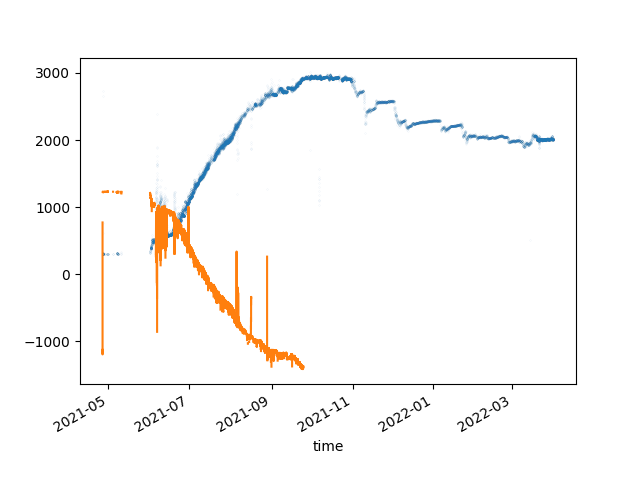

In [256]:
df3 = df['mb_distance'].apply(lambda x: np.median(np.array(x)))
plt.figure()
df3.plot(style=".", alpha=.5, ms=.1)
snow_depth.plot()
plt.show()

In [255]:
print('     Data range: {} - {}'.format(date_start,date_end))
year_hydro = []
for node_last_melt in node['date_last_melt']:
    year_hydro.append(node_last_melt['date'])
d=1
str_hydro_year = '     Period {} - {}:'.format(year_hydro[d-1],year_hydro[d])
print('{} No data for hydrological year'.format(str_hydro_year))
date_snow = []
dist_surf_sensor= []
snow_depth = []
offset = []       
for node_snow in node['snow']: 
    if node_snow['usage'] == 'calibration':
        date = node_snow['date']
        print(date)
        if (date >= date_start and date < date_end) and (date >= year_hydro[d-1] and date < year_hydro[d]):
            print(date)
            date_snow = date
            dist_surf_sensor = node_snow['dist_surf_sensor']
            snow_depth = node_snow['snow_depth']
            offset = node_snow['offset']
            if node_snow['dist_surf_sensor'] is None or node_snow['snow_depth'] is None:
                print("{} No calibration data for hydrological year".format(str_hydro_year))

height_sensor_to_ice = dist_surf_sensor + offset + snow_depth
print('{} Apply snow calibration ... {} + {} + {} = {} mm on {}'.format(str_hydro_year, dist_surf_sensor, snow_depth,
                                                                           offset, height_sensor_to_ice, date_snow))
snow_depth = height_sensor_to_ice - df3[year_hydro[d-1]:year_hydro[d]]
snow_depth


     Data range: 2021-04-26 - 2022-04-01
     Period 2020-09-01 - 2021-09-25: No data for hydrological year
2021-04-26
2021-04-26
2021-09-26
2022-05-05
2022-10-15
2023-04-23
2024-04-08
2024-04-16
     Period 2020-09-01 - 2021-09-25: Apply snow calibration ... 1240 + 240 + 50 = 1530 mm on 2021-04-26


time
2021-04-26 13:00:01       NaN
2021-04-26 13:10:01       NaN
2021-04-26 13:20:01       NaN
2021-04-26 13:30:01     771.0
2021-04-26 13:40:01   -1197.0
                        ...  
2021-09-24 23:10:01   -1382.0
2021-09-24 23:20:01   -1379.0
2021-09-24 23:30:01       NaN
2021-09-24 23:40:01       NaN
2021-09-24 23:50:01   -1382.0
Name: mb_distance, Length: 21311, dtype: float64

In [187]:
node['date_last_melt']

[{'date': datetime.date(2020, 9, 1), 'source': 'default', 'author': 'PML'},
 {'date': datetime.date(2021, 9, 24), 'source': 'record', 'author': 'PML'},
 {'date': datetime.date(2022, 9, 8), 'source': 'record', 'author': 'PML'},
 {'date': datetime.date(2022, 10, 9), 'source': 'record', 'author': 'PML'},
 {'date': datetime.date(2023, 9, 5), 'source': 'record', 'author': 'PML'},
 {'date': datetime.date(2024, 9, 1), 'source': 'default', 'author': 'PML'},
 {'date': datetime.date(2025, 9, 1), 'source': 'default', 'author': 'PML'}]

     Data range: 2023-04-23 - 2023-11-04
     Period 2020-09-01 - 2021-09-24: No data for hydrological year
     Period 2021-09-24 - 2022-09-01: No data for hydrological year
     Period 2022-09-01 - 2023-09-01: Apply snow calibration ... 130 + 960 + 50 = 1140 mm on 2023-04-23
     Period 2023-09-01 - 2024-09-01: Apply snow calibration ... 340 + 1180 + 50 = 1570 mm on 2024-04-16
     Period 2024-09-01 - 2025-09-01: No data for hydrological year


/tmp/ipykernel_450796/875644286.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['mb_distance'] = calibration_snow(df['mb_distance'],node['snow'], node['date_last_melt'])


<Axes: xlabel='time'>

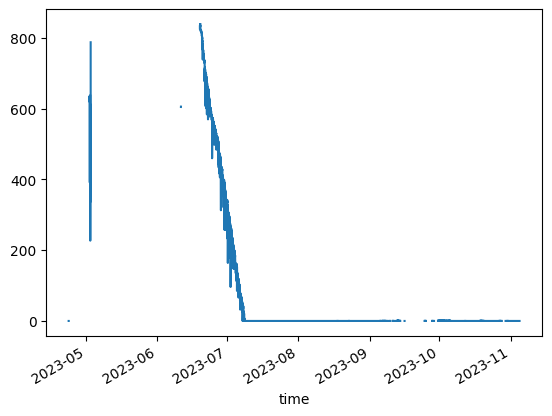

In [20]:
def calibration_snow(df,node_snow,year_hydro):
    ##########################
    # Snow depth calibration #
    ##########################
    
    # Time span
    date_start = df.index.min().date()
    date_end = df.index.max().date()
    print('     Data range: {} - {}'.format(date_start,date_end))

    # Compute median value and assign to new column for output
    df = df.apply(lambda x: np.median(np.array(x)))

    # Extract hydrological station 
    year_hydro = []
    for node_last_melt in node['date_last_melt']:
        year_hydro.append(node_last_melt['date'])

    # loop through hydrological year to calibrate snow depth
    for d in range(1,len(year_hydro)):

        # Constrain loop to calibrate only period with data
        str_hydro_year = '     Period {} - {}:'.format(year_hydro[d-1],year_hydro[d])
        if any(( year_hydro[d] < date_start, year_hydro[d-1] > date_end )):
            print('{} No data for hydrological year'.format(str_hydro_year))
            continue

        # Find calibration parameters matching the hydrological year
        date_snow = []
        dist_surf_sensor= []
        snow_depth = []
        offset = []       
        for node_snow in node['snow']: 
            if node_snow['usage'] == 'calibration':
                date = node_snow['date']
                if date >= year_hydro[d-1] and date <= year_hydro[d]:
                    date_snow = date
                    dist_surf_sensor = node_snow['dist_surf_sensor']
                    snow_depth = node_snow['snow_depth']
                    offset = node_snow['offset']
                    if node_snow['dist_surf_sensor'] is None or node_snow['snow_depth'] is None:
                        print("{} No calibration data for hydrological year".format(str_hydro_year))
                        continue

        # Compute distance between sensor and reference surface i.e. ice or last summer surface
        height_sensor_to_ice = dist_surf_sensor + offset + snow_depth
        print('{} Apply snow calibration ... {} + {} + {} = {} mm on {}'.format(str_hydro_year, dist_surf_sensor, snow_depth,
                                                                           offset, height_sensor_to_ice, date_snow))

        # Calibration of snow depth - Remove negative value i.e. ice melt
        snow_depth = height_sensor_to_ice - df[year_hydro[d-1]:year_hydro[d]]
        snow_depth[snow_depth<0] = 0

        # Assign in dataframe
        df[year_hydro[d-1]:year_hydro[d]] = snow_depth
        #df.plot()
                                              
    return df
    ##########################
df2['mb_distance'] = calibration_snow(df['mb_distance'],node['snow'], node['date_last_melt'])
df2['mb_distance'].plot()

In [10]:
QC_todo = None
if QC_todo: print('True')

In [232]:
date_snow = []
dist_surf_sensor= []
snow_depth = []
for node_snow in node['snow']: 
    if node_snow['usage'] == 'calibration':
        date = node_snow['date']
        date_snow.append(date)
        if date >= year_hydro[d-1] and date <= year_hydro[d]:
            dist_surf_sensor.append(node_snow['dist_surf_sensor'])
            snow_depth.append(node_snow['snow_depth'])
date_snow #dist_surf_sensor #snow_depth

[datetime.date(2021, 4, 26),
 datetime.date(2021, 9, 25),
 datetime.date(2022, 4, 29),
 datetime.date(2022, 10, 9),
 datetime.date(2023, 4, 23),
 datetime.date(2023, 9, 5),
 datetime.date(2024, 4, 16)]

     Data range: 2021-04-29 - 2022-04-09
     Hydrological year: 2018-09-01 - 2019-09-14: No data for hydrological year
     Hydrological year: 2019-09-14 - 2020-09-01: No data for hydrological year
     Hydrological year: 2020-09-01 - 2021-09-25: Apply snow calibration ... 50 + 1440 = 1490 mm on 2021-04-29
     Hydrological year: 2021-09-25 - 2022-09-01: Apply snow calibration ... -3 + 1600 = 1597 mm on 2022-04-09
     Hydrological year: 2022-09-01 - 2023-09-01: No data for hydrological year


<AxesSubplot:xlabel='time'>

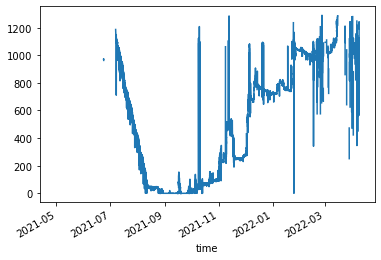

In [174]:
df2['mb_distance'] = calibration_snow(df['mb_distance'],node['snow'],node['date_last_melt'])
df2['mb_distance'].plot()

## Metadata handling for MeteoIO

In [ ]:

#df[version['data_sios']]
#node['location']
#node['network']['description']
#'xy({},{},{})'.format(node['location']['easting'],node['location']['northing'],node['location']['elevation'])

# Test dictionary
meteoio_data = [ dict_corres[d][0] for d in version['data_sios'] ]
meteoio_data_corr = [ dict_corres[d][1] for d in version['data_sios'] ]
meteoio_data_scale = [ dict_corres[d][2] for d in version['data_sios'] ]
print(meteoio_data)
print(meteoio_data_corr)
print(meteoio_data_scale)
print(' '.join([     dict_corres[d][0]  for d in version['data_sios'] ]))
print(' '.join([ str(dict_corres[d][1]) for d in version['data_sios'] ]))
print(' '.join([ str(dict_corres[d][2]) for d in version['data_sios'] ]))
'TIMESTAMP {}'.format(' '.join([dict_corres[d][0]  for d in version['data_sios'] ]))
'0 {}'.format(' '.join([str(dict_corres[d][1]) for d in version['data_sios'] ]))
'1 {}'.format(' '.join([ str(dict_corres[d][2]) for d in version['data_sios'] ]))

print(config_ini['Input']['CSV_FIELDS'])
print(config_ini['Input']['CSV_UNITS_OFFSET'])
print(config_ini['Input']['CSV_UNITS_MULTIPLIER'])
#config_ini['Input']['CSV_FIELDS']='TIMESTAMP {}'.format(' '.join(data_meteoio))
config_ini['Input']['CSV_FIELDS']='TIMESTAMP {}'.format(' '.join([dict_corres[d][0]  for d in version['data_sios'] ]))
config_ini['Input']['CSV_UNITS_MULTIPLIER']='1 {}'.format(' '.join([str(dict_corres[d][1]) for d in version['data_sios'] ]))
config_ini['Input']['CSV_UNITS_OFFSET']='0 {}'.format(' '.join([ str(dict_corres[d][2]) for d in version['data_sios'] ]))

## Test rolling window

In [79]:
node['snow']

[{'date': datetime.date(2021, 4, 26),
  'dist_surf_sensor': 80,
  'snow_depth': 1380,
  'offset': 50,
  'source': 'field observation',
  'usage': 'calibration',
  'pers': 'PML'},
 {'date': datetime.date(2021, 9, 25),
  'dist_surf_sensor': 2485,
  'snow_depth': 0,
  'offset': 0,
  'source': 'record analysis',
  'usage': 'calibration',
  'pers': 'PML'},
 {'date': datetime.date(2022, 4, 1),
  'dist_surf_sensor': 1440,
  'snow_depth': 990,
  'offset': 50,
  'source': 'field observation',
  'usage': 'validation',
  'pers': 'PML'},
 {'date': datetime.date(2023, 4, 11),
  'dist_surf_sensor': 3035,
  'snow_depth': 1140,
  'offset': 50,
  'source': 'field observation',
  'usage': 'calibration',
  'pers': 'PML'},
 {'date': datetime.date(2023, 4, 23),
  'dist_surf_sensor': 130,
  'snow_depth': 960,
  'offset': 50,
  'source': 'field observation',
  'usage': 'calibration',
  'pers': 'SF'},
 {'date': datetime.date(2024, 4, 8),
  'dist_surf_sensor': 1610,
  'snow_depth': 1400,
  'offset': 50,
  'sou

In [52]:
# Query database
df = query.query('postgresql',
                 name='sw-120',
                 fields='mb_distance',
                 time__gte=datetime.datetime(2022, 4, 27, 12, 40, 1),
                 time__lte=datetime.datetime(2023, 4, 16, 0, 0),
                 limit=2000000000000)
df['mb_median'] = df.mb_distance.apply(lambda x: np.median(np.array(x)))

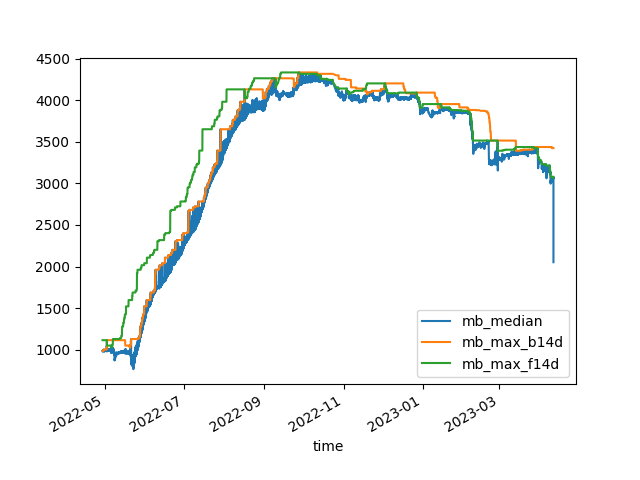

In [78]:
df['mb_max_f7d'] =  df.mb_median[::-1].rolling(window='7d',  min_periods=7).max()
df['mb_max_f14d'] = df.mb_median[::-1].rolling(window='14d', min_periods=7).max()
df['mb_max_f21d'] = df.mb_median[::-1].rolling(window='21d', min_periods=7).max()
df['mb_max_b7d'] =  df.mb_median.rolling(window='7d',  min_periods=7).max()
df['mb_max_b14d'] = df.mb_median.rolling(window='14d', min_periods=7).max()
df['mb_max_b21d'] = df.mb_median.rolling(window='21d', min_periods=7).max()
#df['mb_max2'] = df.mb_max.where(df.mb_max < df.mb_max.max())
plt.figure()
df.mb_median.plot()
#df.mb_max_b7d.plot()
df.mb_max_b14d.plot()
#df.mb_max_b21d.plot()
#df.mb_max_f7d.plot()
df.mb_max_f14d.plot()
#df.mb_max_f21d.plot()
#df.mb_max2.plot()
plt.legend()
plt.show()

In [231]:
import glob
## Merge yearly netcdf into one file using an f-string
# Assign filenames
folder_output = "data_qc"
node_id = "sw-110"
file_path = '{}/aws-{}'.format(folder_output,node_id)
file_nc = '{}.nc'.format(file_path)
print('---> Merge Netcdf into: {}/aws-{}.nc'.format(folder_output,node['id']))


# Remove old or temporary files
if os.path.isfile(file_nc): os.remove(file_nc)
for file_tmp in glob.glob('{}*.tmp'.format(file_path)):
    os.remove(file_tmp)

# Loop through yearly files to add empty variables
for file_year in glob.glob('{}-*.nc'.format(file_path)):
    print('---> Process: {}'.format(file_year))

    # Extract header as textfile
    file_header = '{}/temp_header.txt'.format(folder_output)
    header_as_textfile = 'ncks -m {} > {}'.format(file_year,file_header)
    subprocess.run([header_as_textfile], shell=True)

    # Add empty variables when missing in header
    with open(file_header) as f:
        f_text = ' '.join(f.read().split())
        for var in ["ps", "hur", "ta", "ts", "ws", "dw", "snd"]:
            print(var)
            if not '{}:'.format(var) in f_text:
                print('---> Add empty variable: {}'.format(var))
                add_empty_variable = 'ncap2 -s "{}=0.0" {} -O {}'.format(var, file_year, file_year)
#                subprocess.run([add_empty_variable], shell=True)
    # Clean
    #if os.path.isfile(file_header): os.remove(file_header)

# Mere netcdf yearly files into one
merge_netcdf = 'ncrcat {}-*.nc -o {}'.format(file_path, file_nc)
#subprocess.run(merge_netcdf, shell=True)#, capture_output=True, text=True


---> Merge Netcdf into: data_qc/aws-sw-130.nc
---> Process: data_qc/aws-sw-110-20230423-20240408.nc
ps
hur
ta
ts
ws
dw
snd
---> Process: data_qc/aws-sw-110-20220429-20230411_test.nc
ps
hur
ta
ts
ws
dw
snd
---> Process: data_qc/aws-sw-110-20220429-20230411.nc
ps
hur
ta
ts
ws
dw
snd


In [229]:
with open(file_header) as f:
    data = ' '.join(f.read().split())
    for var in ["ps", "hur", "ta", "ts", "ws", "dw", "snd"]:
        print('{}:'.format(var))
        if not '{}:'.format(var) in data:
            print('---> Add empty variable: {}'.format(var))

ps1:
---> Add empty variable: ps1
hur:
ta:
ts:
ws:
dw:
snd:
